In [2]:
import numpy as np
import control.matlab as m
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.interpolate import interp1d

# Header

In [3]:
'''
PARÂMETROS GERAIS
'''
PATH_IMAGES = Path('imagesAvl2')

param       = {'color':'lightgrey', 'linestyle':'--', 'linewidth':2, 'edgecolor':'k', 'alpha':1, 'hatch':'/'}
tam         = (20,5)

'''
FUNÇÕES ÚTEIS
'''
def epsf(a:float)->float:
    return (10**(-0.1*a) -1)

def savefig(fig:plt, name:str, format:str = 'png', dpi:int = 720, path:Path = PATH_IMAGES) -> None:
    path.mkdir(exist_ok=True)
    if not path.joinpath(f'{name}.{format}').exists():
        fig.savefig(path.joinpath(f'{name}.{format}'), format = format, dpi = dpi)

'''
FILTRO DE BUTTERWORTH
'''
def thetam (n:int)->np.ndarray:
    aux     = 0 if n%2 == 0 else 1
    mfinal  = (n-aux)/2 - 1
    m       = np.arange(0, mfinal+1)
    
    return np.pi*(2*m + n + 1)/(2*n)

def FT(n:int, R:float)-> any:
        print(10*'-'+'BUTTERWORTH FILTER'+10*'-')
        if n > 4:
            print(f'--> Filtro reduzido de {n}th para 4th ordem')
            n = 4
        sigma_m = R*np.cos(thetam(n))
        omega_m = R*np.sin(thetam(n))
        exp     = 0 if n%2 == 0 else 1

        s  = m.tf('s')
        
        B1 = -2*sigma_m
        B2 = sigma_m**2 + omega_m**2

        aux = np.array([1])
        for i in range(len(sigma_m)):
            a   = np.array([1, B1[i], B2[i]])
            aux = np.polymul(aux,a)
        
        h1 = lambda S: sum([S**j *aux[j] for j in range(len(aux))])
        h2 = lambda S: (S+R)**(exp)
        H  = lambda S: R**(exp)*np.prod(B2)/(h1(S)*h2(S))

        # Prints
        print('\n--> Alocação dos Polos:')
        print(f'theta_m\t= {np.round(thetam(n),3)} [rad]')
        print(f'theta_m\t= {np.round(np.rad2deg(thetam(n)),3)} [deg]')
        print(f'sigma_m\t= {np.round(sigma_m,3)} [u.c.]')
        print(f'omega_m\t= {np.round(omega_m,3)} [u.c.]') 
        if not n%2 == 0:
            print(f'sigma_r\t= {-R}')
        
        print(f'\n--> Função de transferência normalizada:')
        print(f'B1m\t= {np.round(B1,3)}')
        print(f'B2m\t= {np.round(B2,3)}')
        print(f'Hb\t= {H(s)}')
        return H
        
def analogFilter(H:m.TransferFunction, RAC:tuple = None, BP:bool = False)-> list:
    Ra, C = RAC
    
    G    = sum(H.num[0][0])
    pole = m.pole(H)
    n    = len(pole)
    
    
    n2th = int(n/2)
    n1th = n%2
    a1   = G**(1/(n2th+n1th))

    print('\n'+10*'-'+'analogFilter'+'-'*10)
    print('\n'+f'--> n° 2th order: {n2th}\n')
    Hanal, R, Rba, K = [], [], [], []
    for i in range(n2th):
        b = np.polymul([1, -pole[i]], [1, -pole[i+1]]).real
        aux = m.tf([a1,0,0],b )
        print(f'H{i} = {aux}')
        
        if not RAC == None:
            if BP :
                r   = np.sqrt(2/(b[2]*C**2))
                rba = 3 - np.sqrt(2*b[1]**2/b[2])
                k   = 1 + rba 
            else:
                r   = 1/np.sqrt(b[2]*C**2)
                rba = 2 - (b[1]/np.sqrt(b[2]))
                k   = 1 + rba

            R.append(r)
            Rba.append(rba)
            K.append(k)
            Rb = Ra*rba
                
            print(f'\t--> circuito')
            print(f'\t- R\t= {round(R[i]*1e-3,3)} [kohm]')
            print(f'\t- Rb\t= {round(Rb*1e-3,3)} [kohm]')
            print(f'\t- Rb/Ra\t= {round(Rba[i],3)}')
            print(f'\t- K{i+1}\t= {round(K[i],3)}')

        
        Hanal.append(aux)

        
    print('\n'+f'--> n° 1th order: {n1th}')
    for j in range(n1th):
        b = [1, pole[j+i].real]
        aux1 = m.tf(a1,b )
        print(f'H{i+j} = {aux1}')

        if not RAC == None:
            R.append(1/(b[1]*C))

            print(f'\t--> circuito')
            print(f'\t- R\t= {round(R[j+i]*1e-3,3)} [kohm]')

        Hanal.append(aux1)

    if not RAC == None:
        Ktot = np.prod(np.array(K))    
        if BP:
            Rm = np.prod(np.array(R))
            Cm = C**(n2th+n1th)
            GA = Ktot/(Rm*Cm*G)
        else:
            GA   = Ktot/G

        
        Rx   = GA*Ra
        Ry   = Rx/(GA -1)

        print('\n'+f'--> Implementação: divisor de tensão')
        print(f'\tGtot = {round(G,3)}')
        print(f'\tKtot = {round(Ktot,3)}')
        print(f'\tGA\t = {round(GA,3)}')
        print(f'\tRx\t = {round(Rx*1e-3,3)} [kohm]')
        print(f'\tRy\t = {round(Ry*1e-3,3)} [kohm]')


    return Hanal


# Filtro de Butterworth

## Projeto do filtro passa-baixas discreto

#### --> Dados de entrada

In [10]:
# Dados gerais
matricula   = np.array([1,8,2,0,2,7,7,2])
factor      = len(matricula)/2

# Filtro passa-baixas
apass       = -3                     #[dB]
n           = 5
fpass       = sum(matricula)/factor  #[Hz]
omega0      = 2*np.pi*fpass

print(10*'-'+'Passa-baixas'+'-'*10)
print(f'apass\t= {apass}\t\tdB')
print(f'nº order = {n}\t\t')
print(f'fpass\t= {fpass}\t\tHz')
print(f'omega0\t= {round(omega0,3)}\trad/s')

----------Passa-baixas----------
apass	= -3		dB
nº order = 5		
fpass	= 7.25		Hz
omega0	= 45.553	rad/s


#### --> Passa-baixas normalizado

In [5]:
# fator de ajuste
eps = np.sqrt(epsf(apass))

# ordem do filtro
nb  = np.log10(epsf(astop)/epsf(apass))/(2*np.log10(omegarH))
n   =  round(nb)+1 if not nb%1 == 0 else nb

print(f'epsilon\t= {round(eps,3)}')
print(f'nb\t= {round(nb,3)} ({n}th order)')

# alocação dos polos
n = n if n<=4 else 4
R = eps**(-1/(n))

print(f'R\t= {round(R,3)} [u.c] (p/n = {n})\n')

# função de transferência
s   = m.tf('s')
H   = FT(n,R)
HrL = H(s)


# Diagrama de Bode
mag, phase, omega = m.bode(HrL, plot = True)
magdB = 20*np.log10(mag)
savefig(plt.gcf(), 'bodePBnorm')
plt.show()


Xtemp = lambda x0,xf: [x0, xf]
Ytemp = lambda a0,af: [a0, af]
with plt.rc_context({'figure.figsize':tam}):

    plt.semilogx(omega, magdB, 'b')
    plt.fill_between(Xtemp(omega[0], 1), Ytemp(apass, apass),Ytemp(astop,astop),**param)
    plt.fill_between(Xtemp(omegarH, 10),Ytemp(0,0),Ytemp(astop,astop), **param)
    
    plt.yticks([0,-3,-18])
    plt.ylim([-18.5,0.1])
    plt.title('Gráfico de Ganho')
    plt.xlabel(r'$\omega$ [rad/s]')
    plt.ylabel('Magnitude [dB]')

    plt.grid(axis = 'both')

    savefig(plt.gcf(), 'ganhoPBnorm')
    plt.show()




NameError: name 'apass' is not defined

#### --> Cálculo do novo valor de atenuação

astop	= -7.699dB


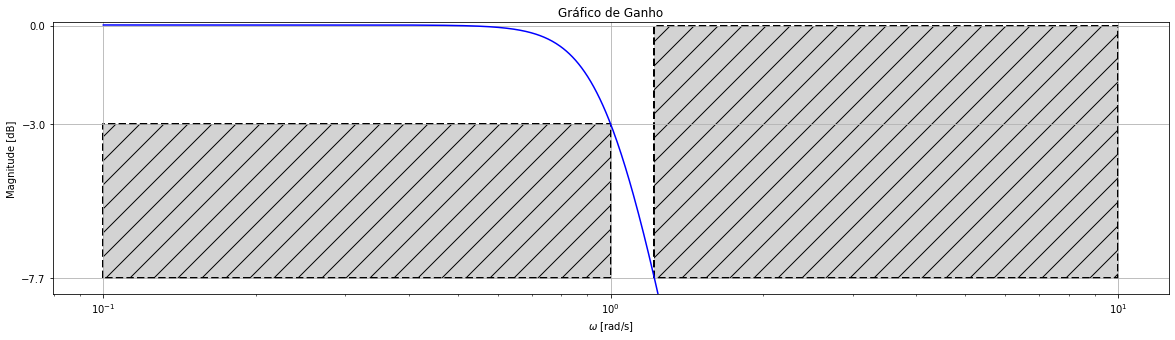

In [323]:
astopNew = -10*np.log10(omegarH**(2*n)*(10**(-0.1*apass) - 1) + 1)
print(f'astop\t= {round(astopNew,3)}dB')

with plt.rc_context({'figure.figsize':tam}):

    plt.semilogx(omega, magdB, 'b')
    plt.fill_between(Xtemp(omega[0], 1), Ytemp(apass, apass),Ytemp(astopNew,astopNew),**param)
    plt.fill_between(Xtemp(omegarH, 10),Ytemp(0,0),Ytemp(astopNew,astopNew), **param)
    
    plt.yticks([0,-3,round(astopNew,2)])
    plt.ylim([-(abs(astopNew)+0.5),0.1])
    plt.title('Gráfico de Ganho')
    plt.xlabel(r'$\omega$ [rad/s]')
    plt.ylabel('Magnitude [dB]')

    plt.grid(axis = 'both')
    
    savefig(plt.gcf(), 'ganhoPBnormAstop')
    plt.show()

#### --> Conversão para o filtro passa-altas

6 states have been removed from the model
HrH	= 
                          1.002 s^4
-------------------------------------------------------------
s^4 + 4.554e+04 s^3 + 1.037e+09 s^2 + 1.383e+13 s + 9.224e+16



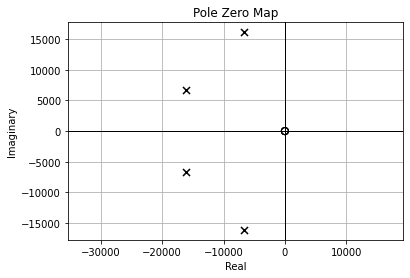

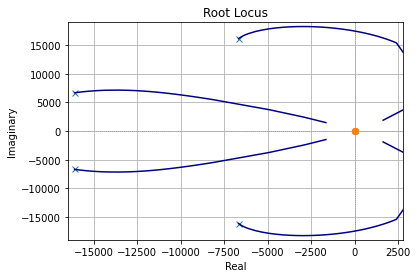

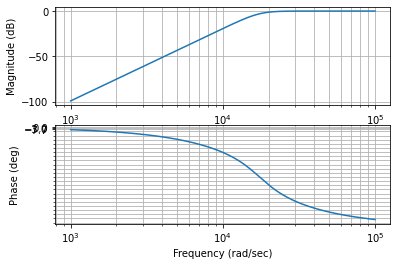

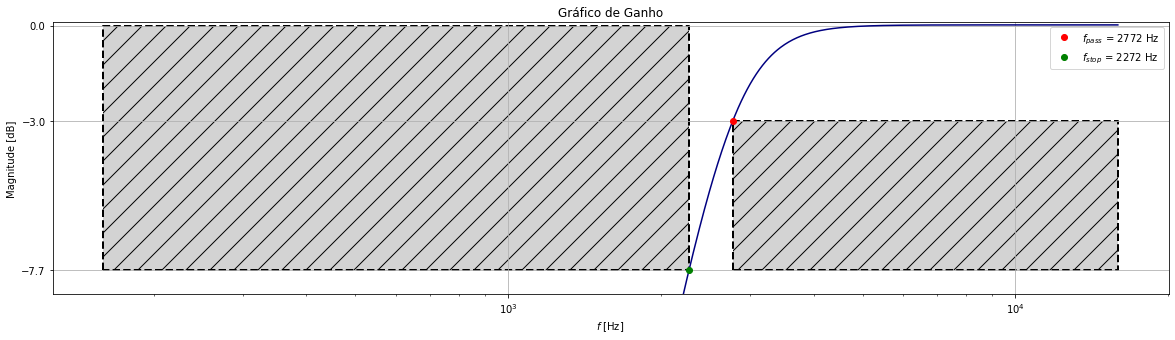

In [324]:
# Função de transferência
s = m.tf('s')
HrH = m.minreal(H(omega0PA/s))
print(f'HrH\t= {HrH}')

# Pole zero map
m.pzmap(HrH, 'b')
plt.grid()

savefig(plt.gcf(), 'pzmapPA')
plt.show()

# Root-Locus
m.rlocus(HrH, grid = False, plotstr = 'navy')
plt.grid()

savefig(plt.gcf(), 'rlocusPA')
plt.show()

# Diagrama de Bode
mag, phase, omega = m.bode(HrH, plot = True, dB = True)
magdB = 20*np.log10(mag)
plt.yticks([0,-3,round(astopNew,2)])
savefig(plt.gcf(), 'bodePA')
plt.show()

magdB   = 20*np.log10(mag)
freqPA  = omega/(2*np.pi)
magdBf  = interp1d(freqPA,magdB)

with plt.rc_context({'figure.figsize':tam}):
    
    plt.semilogx(freqPA, magdB, 'navy')
    plt.fill_between([freqPA[0], fstopPA]   , [0, 0]        , [astopNew, astopNew]  ,  **param)
    plt.fill_between([fpassPA, freqPA[-1]]  , [apass,apass] , [astopNew, astopNew]   ,  **param)

    plt.plot(fpassPA, magdBf(fpassPA),'ro', label = r'$f_{pass}$ = '+f'{round(fpassPA,2)} Hz')    
    plt.plot(fstopPA, magdBf(fstopPA),'go', label = r'$f_{stop}$ = '+f'{round(fstopPA,2)} Hz')    
    
    plt.yticks([0,-3,round(astopNew,2)])
    plt.ylim([-(abs(astopNew)*1.1),0.1])
    plt.title('Gráfico de Ganho')
    plt.xlabel(r'$f$ [Hz]')
    plt.ylabel('Magnitude [dB]')

    plt.grid(axis = 'both')
    plt.legend()

    savefig(plt.gcf(), 'ganhoPA')
    plt.show()

#### --> Implementação analógica filtro passa-altas

In [325]:
C   = 10e-9  #[F]
Ra  = 100e3 #[ohm]
imp = analogFilter(HrH,(Ra,C))


----------analogFilter----------

--> n° 2th order: 2

H0 = 
          1.001 s^2
-----------------------------
s^2 + 1.334e+04 s + 3.037e+08

	--> circuito
	- R	= 5.738 [kohm]
	- Rb	= 123.463 [kohm]
	- Rb/Ra	= 1.235
	- K1	= 2.235
H1 = 
          1.001 s^2
-----------------------------
s^2 + 2.277e+04 s + 2.148e+08

	--> circuito
	- R	= 6.824 [kohm]
	- Rb	= 44.623 [kohm]
	- Rb/Ra	= 0.446
	- K2	= 1.446

--> n° 1th order: 0

--> Implementação: divisor de tensão
	Gtot = 1.002
	Ktot = 3.232
	GA	 = 3.224
	Rx	 = 322.412 [kohm]
	Ry	 = 144.962 [kohm]
